<a href="https://colab.research.google.com/github/khzouroussama/LunarLander-v2-solver/blob/main/Copy_of_AARN_DQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AARN Project**

*   Khezour Mohamed Oussama (DQL)

*   Khiat Mokhtar (PG)






### *Installing  dependencies*

In [ ]:
!sudo apt update
!apt-get install python-opengl -y
!apt install -y xvfb python-opengl ffmpeg x11-utils
# For rendering environment, you can use pyvirtualdisplay.
!pip install gym scipy
!pip install pyvirtualdisplay piglet box2d-py
# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 1s (232 kB/s)
Reading package lists... Done
Building dependency tree       
Reading s

In [ ]:

# To activate virtual display 
# need to run a script once for training an agent as follows
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

#
# Import libraries
#
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## **The Deep Q-Learning Algorithm implementation**  

In [ ]:
# khezour mohamed oussama 
# khzouroussama@gmail.com
import numpy as np
from tensorflow import keras
from keras.layers import Dense 
from keras.optimizers import Adam

class DQNet(keras.Model):
    def __init__(self, n_actions, hl1=256, hl2=256):
        super(DQNet, self).__init__()
        self.l1 = Dense(hl1, activation='relu')
        self.l2 = Dense(hl2, activation='relu')
        self.ol = Dense(n_actions, activation=None)

    def call(self, state):
        x = self.l1(state)
        x = self.l2(x)
        return self.ol(x)

class DQLagent:
    def __init__(self, gamma, n_actions,learning_rate, epsilon, batch_size,
                 input_dims,memory_size=1000000):
        self.epsilon = epsilon
        self.eps_dec = 1e-3
        self.eps_min = 0.01
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_space = [i for i in range(n_actions)]
        self.memory = ReplayBuffer(memory_size, input_dims)
        self.Q_net = DQNet(n_actions)

        self.Q_net.compile(optimizer=Adam(learning_rate=learning_rate))
    
    def reset(self):
        self.Q_net = DQNet(n_actions)
        self.Q_net.compile(optimizer=Adam(learning_rate=learning_rate))
        
    def act(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            action = np.argmax(self.Q_net(np.array([observation])))

        return action

    def learn(self):
        if self.memory.counter < self.batch_size:
            return

        states, actions, rewards, states_, dones = self.memory.sample(self.batch_size)

        loss_fun = keras.losses.MeanSquaredError()
        with tf.GradientTape() as tape:
          q  = self.Q_net(states)
          q_ = self.Q_net(states_)
          q_target = np.copy(q)
          range = np.arange(self.batch_size, dtype=np.int32)
          q_target[range, actions] = rewards + self.gamma * np.max(q_, axis=1) * dones
          q_loss = loss_fun(q_target,q)
          # loss = tf.reduce_mean(tf.square(q_target - q))

        gradient = tape.gradient(q_loss, self.Q_net.trainable_variables)
        self.Q_net.optimizer.apply_gradients(zip(gradient, self.Q_net.trainable_variables))

        if self.epsilon > self.eps_min  :
           self.epsilon = self.epsilon - self.eps_dec 
        else :
           self.epsilon = self.eps_min
      

class ReplayBuffer:
    def __init__(self, max_size, input_dims):
        self.size = max_size
        self.counter = 0
        self.state = np.zeros((self.size, *input_dims),dtype=np.float32)
        self.state_ = np.zeros((self.size, *input_dims),dtype=np.float32)
        self.actions = np.zeros(self.size, dtype=np.int32)
        self.rewards = np.zeros(self.size, dtype=np.float32)
        self.teminals = np.zeros(self.size, dtype=np.int32)

    def sample(self, batch_size):
        max_mem = min(self.counter, self.size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state[batch]
        new_states = self.state_[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]
        terminal = self.teminals[batch]

        return states, actions, rewards, new_states, terminal

    def store(self, state, action, reward, state_, done):
        index = self.counter % self.size
        self.counter += 1
        self.state[index] = state
        self.state_[index] = state_
        self.rewards[index] = reward
        self.actions[index] = action
        self.teminals[index] = 1 - int(done)


## **Monte-Carlo (REINFORCE) policy gradient algorithm**

In [ ]:
#RINFORCE
# khiat mokhtar
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam

class PGNet(keras.Model):
    def __init__(self, n_actions, lay1=256, lay2=256):
        super(PGNet, self).__init__()
        self.lay1 = lay1
        self.lay2 = lay2
        self.n_actions = n_actions
        self.layer1 = Dense(self.lay1, activation='relu')
        self.layer2 = Dense(self.lay2, activation='relu')
        self.pi     = Dense(n_actions, activation='softmax')

    def call(self, state):
        y = self.layer1(state)
        y = self.layer2(y)
        pi = self.pi(y)
        return pi

class PGAgent:
    def __init__(self, lr=0.0005, gamma=0.5, n_actions=4):

          self.lr = lr
          self.gamma = gamma
          self.n_actions = n_actions
          self.list_states = []
          self.list_actions = []
          self.list_rewards = []
          self.policy = PGNet(n_actions=n_actions)
          self.policy.compile(optimizer=Adam(learning_rate=self.lr))
    
    def reset(self):
          self.policy = PGNet(n_actions=n_actions)
          self.policy.compile(optimizer=Adam(learning_rate=self.lr))

    def choose_action(self, observation):
          state = tf.convert_to_tensor([observation], dtype=tf.float32)
          probs = self.policy(state)
          action_probs = tfp.distributions.Categorical(probs=probs)
          action = action_probs.sample()

          return action.numpy()[0]
    
    def store(self, observation, action, reward):
          self.list_states.append(observation)
          self.list_actions.append(action)
          self.list_rewards.append(reward)

    def learn(self):
          actions = tf.convert_to_tensor(self.list_actions, dtype=tf.float32)
          rewards = np.array(self.list_rewards)

          G = np.zeros_like(rewards)
          for t in range(len(rewards)):
              sum = 0
              discount_factor = 1
              for k in range(t, len(rewards)):
                  sum += rewards[k] * discount_factor
                  discount_factor *= self.gamma
              G[t] = sum
          
          with tf.GradientTape() as tape:
              loss = 0
              for idx, (g, state) in enumerate(zip(G, self.list_states)):
                  state = tf.convert_to_tensor([state], dtype=tf.float32)
                  probs = self.policy(state)
                  action_probs = tfp.distributions.Categorical(probs=probs)
                  log_prob = action_probs.log_prob(actions[idx])
                  loss += -g * tf.squeeze(log_prob)

          gradient = tape.gradient(loss, self.policy.trainable_variables)
          self.policy.optimizer.apply_gradients(zip(gradient, self.policy.trainable_variables))

          self.list_states = []
          self.list_actions= []
          self.list_rewards = []

# **Training the agents**

### **Training the DQN agent**

#### **parameter tuning**

In [ ]:
#1
import tensorflow as tf
import gym

env = gym.make('LunarLander-v2')

def trainDQL( episodes , lr , gamma , epsilon = 1  ) :
    dql_agent = DQLagent(
        gamma=gamma,
        epsilon=1.0,
        learning_rate=lr,
        batch_size=64,
        memory_size=1000000,
        input_dims=env.observation_space.shape,
        n_actions=env.action_space.n
    )
    scores = []
    epsilons = []
    for i in range(episodes):
        score = 0
        done = False
        observation = env.reset()
        while not done:
            #env.render()
            action = dql_agent.act(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            dql_agent.memory.store(observation, action, reward, observation_, done)
            observation = observation_
            dql_agent.learn()
        scores.append(score)
        epsilons.append(dql_agent.epsilon)
        print('episode ', i, 'score %.2f' % score,'average score %.2f' %  np.mean(scores[-100:]))

    scores = np.array(scores)
    scores = scores[scores > -400] 
    return scores , epsilons , dql_agent

In [ ]:
# parameter tunning 
episodes = 500
dql_scores1 , _ , _ = trainDQL(episodes = episodes , lr = 0.001  , gamma = 0.99 ,epsilon=1)
dql_scores2 , _ , _ = trainDQL(episodes = episodes , lr = 0.001  , gamma = 0.99 ,epsilon=0.5)
dql_scores3 , _ , _ = trainDQL(episodes = episodes , lr = 0.001  , gamma = 0.99 )

episode  0 score -178.82 average score -178.82
episode  1 score -322.78 average score -250.80


KeyboardInterrupt: ignored

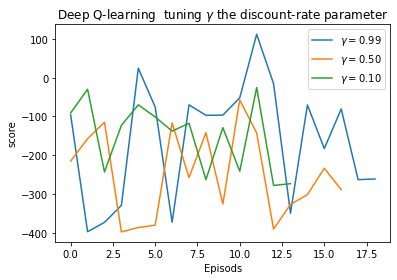

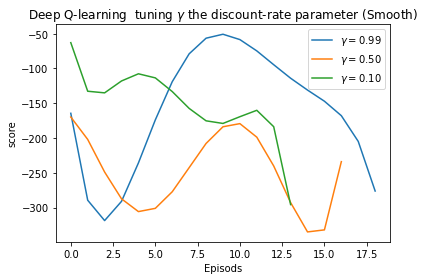

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(dql_scores1),dtype=np.int32) , dql_scores1 , label = 'learning rate  = 0.001')
plt.plot(np.arange(len(dql_scores2),dtype=np.int32) , dql_scores2 , label = '$learning rate = 0.100$')
plt.plot(np.arange(len(dql_scores3),dtype=np.int32) , dql_scores3 , label = '$learning rate = 0.500$')

plt.legend()
plt.xlabel('Episods')
plt.ylabel('score')
plt.title('Deep Q-learning  tuning $\gamma$ the discount-rate parameter ')
plt.savefig('DQL_gamma_1.svg')
plt.show()

# print smooth lines 
dql_scores1_ = np.poly1d(np.polyfit(np.arange(len(dql_scores1),dtype=np.int32),dql_scores1,5))(np.arange(len(dql_scores1),dtype=np.int32))
dql_scores2_ = np.poly1d(np.polyfit(np.arange(len(dql_scores2),dtype=np.int32),dql_scores2,5))(np.arange(len(dql_scores2),dtype=np.int32))
dql_scores3_ = np.poly1d(np.polyfit(np.arange(len(dql_scores3),dtype=np.int32),dql_scores3,5))(np.arange(len(dql_scores3),dtype=np.int32))

plt.plot(np.arange(len(dql_scores1_),dtype=np.int32) , dql_scores1_ , label = '$\gamma = 0.99$')
plt.plot(np.arange(len(dql_scores2_),dtype=np.int32) , dql_scores2_ , label = '$\gamma = 0.50$')
plt.plot(np.arange(len(dql_scores3_),dtype=np.int32) , dql_scores3_ , label = '$\gamma = 0.10$')

plt.legend()
plt.xlabel('Episods')
plt.ylabel('score')
plt.title('Deep Q-learning  tuning $\gamma$ the discount-rate parameter (Smooth)')
plt.savefig('DQL_gamma_2.svg')
plt.show()

#### **full training**

In [ ]:
#2
# Running a full Test
dql_FINAL_score ,epsilons , dql_agent  = trainDQL(episodes = 200 , lr = 0.001  , gamma = 0.99 )

episode  0 score -123.77 average score -123.77
episode  1 score -368.74 average score -246.25
episode  2 score -107.41 average score -199.97
episode  3 score -53.30 average score -163.31
episode  4 score -320.59 average score -194.76
episode  5 score -105.49 average score -179.88
episode  6 score -470.20 average score -221.36
episode  7 score -414.68 average score -245.52
episode  8 score -704.43 average score -296.51
episode  9 score -464.61 average score -313.32
episode  10 score -454.08 average score -326.12
episode  11 score -407.29 average score -332.88
episode  12 score -559.88 average score -350.34
episode  13 score -487.72 average score -360.15
episode  14 score -627.46 average score -377.98
episode  15 score -216.07 average score -367.86
episode  16 score -454.12 average score -372.93
episode  17 score -316.73 average score -369.81
episode  18 score 1.47 average score -350.27
episode  19 score -354.68 average score -350.49
episode  20 score -422.79 average score -353.93
episod

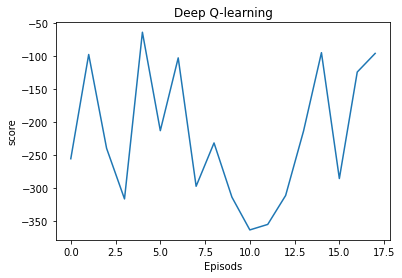

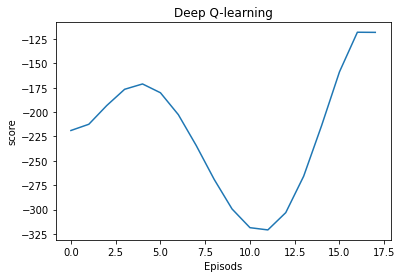

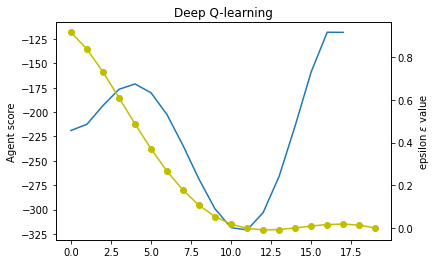

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(dql_FINAL_score),dtype=np.int32) , dql_FINAL_score , label = 'Agent score')
plt.xlabel('Episods')
plt.ylabel('score')
plt.title('Deep Q-learning')
plt.savefig('DQL_final.pdf')
plt.show()

# print smooth lines 
dql_FINAL_score_ = np.poly1d(np.polyfit(np.arange(len(dql_FINAL_score),dtype=np.int32),dql_FINAL_score,5))(np.arange(len(dql_FINAL_score),dtype=np.int32))
plt.plot(np.arange(len(dql_FINAL_score_),dtype=np.int32) , dql_FINAL_score_ , label = 'Agent score')
plt.xlabel('Episods')
plt.ylabel('score')
plt.title('Deep Q-learning')
plt.savefig('DQL_final_smooth.pdf')
plt.show()

# print smooth lines (score -epsilon)
epsilons_ = np.poly1d(np.polyfit(np.arange(len(epsilons),dtype=np.int32),epsilons,5))(np.arange(len(epsilons),dtype=np.int32))

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(len(dql_FINAL_score_),dtype=np.int32), dql_FINAL_score_)
ax1.set_ylabel('Agent score')

ax2 = ax1.twinx()
ax2.plot(np.arange(len(epsilons_),dtype=np.int32), epsilons_ , 'oy-')
ax2.set_ylabel('epsilon $\epsilon$ value')

plt.title('Deep Q-learning')
plt.savefig('DQL_final_eps_smooth.pdf')
plt.show()

### **Training the PG agent**

In [ ]:
#3
# PG agent training
import tensorflow as tf
import gym

env = gym.make('LunarLander-v2')

def trainPG( episodes , lr , gamma  ) :
    pg_agent = PGAgent(lr=lr,gamma=gamma,n_actions=env.action_space.n)
    scores = []
    for i in range(episodes):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = pg_agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            pg_agent.store(observation, action, reward)
            observation = observation_
            score += reward
        scores.append(score)
        pg_agent.learn()
        avg_score = np.mean(scores[-100:])
        print('episode: ', i,'score: %.1f' % score,
            'average score %.1f' % avg_score)
        

    scores = np.array(scores)
    scores = scores[scores > -400] 
    return pg_agent , scores

#### **parameter tuning**

In [ ]:
# parameter tunning 
episodes = 2000
_, pg_scores1 = trainPG(episodes = episodes , lr = 0.001  , gamma = 0.99 )
_,pg_scores2 = trainPG(episodes = episodes , lr = 0.001  , gamma = 0.50 )
_,pg_scores3 = trainPG(episodes = episodes , lr = 0.001  , gamma = 0.10 )

In [ ]:
# Ploting the results 
import matplotlib.pyplot as plt

plt.plot(np.arange(len(pg_scores1),dtype=np.int32) , pg_scores1 , label = '$\gamma = 0.99$')
plt.plot(np.arange(len(pg_scores2),dtype=np.int32) , pg_scores2 , label = '$\gamma = 0.50$')
plt.plot(np.arange(len(pg_scores3),dtype=np.int32) , pg_scores3 , label = '$\gamma = 0.10$')

plt.legend()
plt.xlabel('Episods')
plt.ylabel('score')
plt.title('Deep Q-learning tuning $\gamma$ the discount-rate parameter ')

plt.show()

#### **full training**

In [ ]:
#4
pg_agent ,pg_FINAL_score = trainPG(episodes = 100 , lr = 0.0003  , gamma = 0.99 )

episode:  0 score: -129.1 average score -129.1
episode:  1 score: -101.8 average score -115.5
episode:  2 score: -116.2 average score -115.7
episode:  3 score: -113.5 average score -115.2
episode:  4 score: -322.1 average score -156.5
episode:  5 score: -191.9 average score -162.4
episode:  6 score: -121.9 average score -156.6
episode:  7 score: -491.2 average score -198.5
episode:  8 score: -174.0 average score -195.7
episode:  9 score: -175.9 average score -193.8
episode:  10 score: -89.8 average score -184.3
episode:  11 score: -534.5 average score -213.5
episode:  12 score: -103.5 average score -205.0
episode:  13 score: -101.6 average score -197.6
episode:  14 score: -352.5 average score -208.0
episode:  15 score: -383.5 average score -218.9
episode:  16 score: -283.0 average score -222.7
episode:  17 score: -119.9 average score -217.0
episode:  18 score: -138.8 average score -212.9
episode:  19 score: -120.1 average score -208.2
episode:  20 score: -125.3 average score -204.3
epi

# **Comparing the two approches**

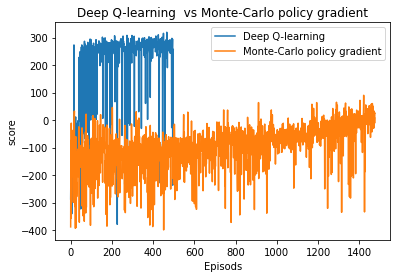

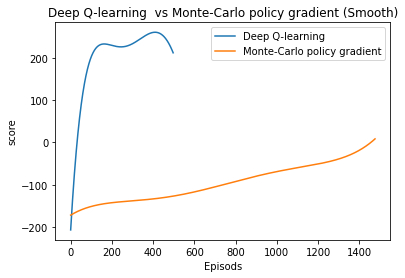

In [ ]:
#5
#comparing
import matplotlib.pyplot as plt

plt.plot(np.arange(len(dql_FINAL_score),dtype=np.int32) , dql_FINAL_score , label = 'Deep Q-learning')
plt.plot(np.arange(len(pg_FINAL_score),dtype=np.int32) , pg_FINAL_score , label = 'Monte-Carlo policy gradient')

plt.legend()
plt.xlabel('Episods')
plt.ylabel('score')
plt.title('Deep Q-learning  vs Monte-Carlo policy gradient')
plt.savefig('DQLvsPG.pdf')
plt.show()

# print smooth lines 
dql_scores_ = np.poly1d(np.polyfit(np.arange(len(dql_FINAL_score),dtype=np.int32),dql_FINAL_score,5))(np.arange(len(dql_FINAL_score),dtype=np.int32))
pg_scores_ = np.poly1d(np.polyfit(np.arange(len(pg_FINAL_score),dtype=np.int32),pg_FINAL_score,5))(np.arange(len(pg_FINAL_score),dtype=np.int32))

plt.plot(np.arange(len(dql_scores_),dtype=np.int32) , dql_scores_ , label = 'Deep Q-learning')
plt.plot(np.arange(len(pg_scores_),dtype=np.int32) , pg_scores_ , label = 'Monte-Carlo policy gradient')

plt.legend()
plt.xlabel('Episods')
plt.ylabel('score')
plt.title('Deep Q-learning  vs Monte-Carlo policy gradient (Smooth)')
plt.savefig('DQLvsPG_SMOOTH.pdf')
plt.show()

# Testing the **agents**

## Running the DQL agent

In [ ]:
# TEST 
env = wrap_env(gym.make("LunarLander-v2"))

observation = env.reset()
score = 0
while True:
    env.render()
    action = np.argmax(dql_agent.Q_net(np.array([observation])))
    observation, reward, done, info = env.step(action) 

    score += reward
    if done: 
      break;

print(score)
env.close()
show_video()

133.22255939502182


## Running the PG agent

In [ ]:
# 
env = wrap_env(gym.make("LunarLander-v2"))

observation = env.reset()
score = 0
while True:
    env.render()
    action = pg_agent.choose_action(observation)
    observation, reward, done, info = env.step(action) 

    score += reward
    if done: 
      break;

print(score)
env.close()
show_video()

-297.90149217914444
